In [ ]:
# Imports necessários
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Carregar o dataset de vinhos a partir da URL
url = "https://raw.githubusercontent.com/klaytoncastro/idp-machinelearning/main/decision-tree/winequality-merged.csv"
data = pd.read_csv(url)
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


In [ ]:
# Substituindo a variável categórica por numérica
data['color'] = data['color'].replace('red', 0)
data['color'] = data['color'].replace('white', 1)
# Definindo o limiar para corte de vinhos bons como os de qualidade >=7
data['worst'] = np.where(data['quality'] < 7, 1, 0)
data = data.drop(['quality'], axis=1)
data.head()

<ipython-input-4-b3b25f1513fc>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['color'] = data['color'].replace('white', 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,worst
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1


In [ ]:
# Exibir o percentual de cada classe
print(data['worst'].value_counts(normalize=True) * 100)

# Separar os recursos (features) da variável alvo (target)
X = data.drop('worst', axis=1)
y = data['worst']

# Dividir o dataset em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instanciar o modelo de Extra Trees
model = ExtraTreesClassifier(random_state=42)

worst
1    80.344775
0    19.655225
Name: proportion, dtype: float64


In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],  # Testando com mais árvores
    'max_depth': [10, 20, 30],  # Aumentando a profundidade máxima
    'min_samples_split': [2, 5, 10],  # Variando o mínimo de amostras para divisão
    'min_samples_leaf': [1, 2, 4],  # Variando o mínimo de amostras em cada folha
    'bootstrap': [True, False]  # Testando com e sem bootstrap
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             verbose=2)

In [ ]:
# Exibir os melhores parâmetros encontrados
print(f"Melhores parâmetros: {grid_search.best_params_}")

Melhores parâmetros: {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [ ]:
# Testar o modelo otimizado no conjunto de teste
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [ ]:
"""
Calculando e exibindo a matriz de confusão. A orientação padrão é a seguinte:
[0,0]: Verdadeiros Negativos (VN) - Previsões corretamente identificadas como negativas.
[0,1]: Falsos Positivos (FP) - Previsões incorretamente identificadas como positivas.
[1,0]: Falsos Negativos (FN) - Previsões incorretamente identificadas como negativas.
[1,1]: Verdadeiros Positivos (VP) - Previsões corretamente identificadas como positivas.
"""

conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 126  127]
 [  19 1028]]


In [ ]:
"""
Calculando e exibindo as métricas de classificação.
Se algumas classes têm muito mais amostras do que outras, isso pode influenciar o desempenho e confiabilidade do modelo.

O "support" refere-se à quantidade de ocorrências da classe específica no conjunto de dados, sendo útil para verificar desbalanceamentos.
A "macro avg" calcula a média aritmética das métricas (precisão, recall, F1-score) para cada classe, sem considerar o número de instâncias em cada classe (support).
A "weighted avg" calcula a média ponderada das métricas para cada classe, considerando o número de instâncias em cada classe (support).
"""
print("Relatório de Classsificação:")
print(classification_report(y_test, y_pred, zero_division=0))

Relatório de Classsificação:
              precision    recall  f1-score   support

           0       0.87      0.50      0.63       253
           1       0.89      0.98      0.93      1047

    accuracy                           0.89      1300
   macro avg       0.88      0.74      0.78      1300
weighted avg       0.89      0.89      0.88      1300



In [ ]:
# Avaliar o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

Acurácia no conjunto de teste: 0.8877


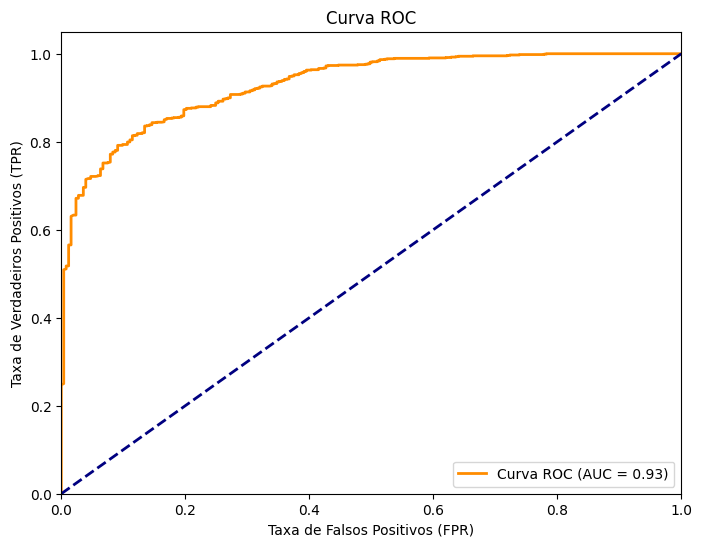

AUC: 0.93


In [20]:
# Prever probabilidades (somente a da classe positiva)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calcular os pontos para a Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calcular a AUC (Área sob a Curva ROC)
roc_auc = auc(fpr, tpr)

# Plotar a Curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

# Exibir a AUC
print(f"AUC: {roc_auc:.2f}")
